## Agent Based Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_rows = 100

In [2]:
import sys
sys.path.append("../") # go to parent dir

In [3]:
print(sys.path)

['C:\\Users\\a.poghosyan\\Documents\\training_simulation\\training_batch_run_workflow\\training_simulator\\notebooks', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\Anaconda3\\envs\\mesaabm\\python310.zip', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\Anaconda3\\envs\\mesaabm\\DLLs', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\Anaconda3\\envs\\mesaabm\\lib', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\Anaconda3\\envs\\mesaabm', '', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\Anaconda3\\envs\\mesaabm\\lib\\site-packages', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\Anaconda3\\envs\\mesaabm\\lib\\site-packages\\win32', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\Anaconda3\\envs\\mesaabm\\lib\\site-packages\\win32\\lib', 'C:\\Users\\a.poghosyan\\AppData\\Local\\Continuum\\Anaconda3\\envs\\mesaabm\\lib\\site-packages\\Pythonwin', '../']


In [4]:
sys.path.append('C:\\Users\\a.poghosyan\\Documents\\training_simulation\\training_batch_run_workflow\\training_simulator\\training_simulator')

<img src="pipelineHLD.png" alt="Aircrew Model Pipeline" width="800"/>

**Inputs**
- Number of iterations
- Number of steps (months)
- Number of trainee
- Course Duration
- Hold Duration
- Capacity 
- Attrition (probability of trainees leaving the pipeline)

**Outputs**
- number of trainees in each course/state at any time step throughout the pipeline.
- average number of trainees on hold at given stage.
- average time spent in hold at given stage per trainee.
- total hold times per trainee.
- average training duration per trainee.
- The confidence intervals


**Advantages**
- Easy to implement and test hypotheses in the absence of aggregate data 
- Extensibility and Flexibility
- Provision of  data driven outcomes on testing different interventions and scenarios.
- Long term forecasting potential.

**Limitations**
- Model cannot capture more granular issues that are highly specific to one or the other stage in the pipeline
- Model is not linked to live data sets and hence only represents a snapshot of when the parameters where last estimated.
- Outputs are stochastic so this can be challenging to validate.


<img src="workflow.png" alt="Aircrew Model Pipeline" width="700"/>

### Modelling Assumptions:

Pipeline: In the initial version the model will take into account Fast Jet Main Pathway courses of Fast Jet Stream including EFT. These courses are mandatory for aircrew trainees to complete MFTS.

- Modelling all of the Pathways can put additional complexity on implementation and then further to testing as numbers are very small. In the future increments of Drake model we will be looking into adding additional features such as refresher courses that will create loopbacks in the linear pipeline.

- **Course Frequency**:  its variable each year and also sometimes in one month two courses are running in parallel. In Drake model we will reflect this through the capacity parameter. If two of the same courses are running in parallel we will assume that its one course with higher capacity.

- **Schedule Concept**: ABM  model will allow to schedule courses by months (e.g if course is repeated twice a year then it will run every  6 time steps). The schedule will not be a parameter that users can change.

- **Extra variance**: To add variance to model output the course capacity and duration parameters will be generated randomly from the intervals Int(duration-SD, duration+SD), Int(capacity-SD, capacity+SD). Over the length of simulation this number will remain static fixed. Running new simulation will generate different numbers within allowed interval.

In [5]:
from training_simulator.run import run_batch
from training_simulator.analysis import (
    make_average_path,
    get_agents_data,
    make_time_series,
    make_quantile_path,
)
from training_simulator.stages import MIOT
from training_simulator.structure import (
    PilotBase,
    PipelineModelBase,
    Stage,
    StageManager,
    State,
)

## Simulation

All states start with the same number of pilots in and the same number waiting to progress

In [6]:
steps = 12 * 3
model_params = {"version": "2.1.3",
    "simulation": {"steps": 120, "start_month": 4, "iterations": 30},
    "streaming":1,
    "init_pilots": {
        "stage1": {"progressing": 0, "hold": 0},
        "stage2": {"progressing": 0, "hold": 0},
        "stage3": {"progressing": 0, "hold": 0},
        "stage4": {"progressing": 0, "hold": 0},
        "stage5": {"progressing": 0, "hold": 0},
        "stage6": {"progressing": 0, "hold": 0},
        "stage7": {"progressing": 0, "hold": 0},
        "stage8": {"progressing": 0, "hold": 0},
        "stage9": {"progressing": 0, "hold": 0},
        "stage10": {"progressing": 0, "hold": 0},
        "stage11": {"progressing": 0, "hold": 0},
        "stage12": {"progressing": 0, "hold": 0},
    },

    "pipeline": {
        "miot": {"new_pilots": 10, "input_rate": 1, "time_hold": 120},
        "stage1": {
            "drop_out_progressing": 0.12,
            "drop_out_hold": 0,
            "capacity_progressing": 21,
            "time_progressing": 2,
            "time_hold": 120,
        },
        "stage2": {
            "drop_out_progressing": 0.05,
            "drop_out_stream": 0.6,
            "drop_out_hold": 0,
            "capacity_progressing": 11,
            "time_progressing": 6,
            "time_hold": 120,
        },
        "stage3": {
            "drop_out_progressing": 0.0,
            "drop_out_hold": 0.0,
            "capacity_progressing": 10,
            "time_progressing": 2,
            "time_hold": 120,
        },
        "stage4": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "time_progressing": 13,
            "capacity_progressing": 4,
            "time_hold": 120,
        },
        "stage5": {
            "drop_out_progressing": 0.2,
            "drop_out_hold": 0,
            "capacity_progressing": 4,
            "time_progressing": 10,
            "time_hold": 120,
        },
        "stage6": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 4,
            "time_progressing": 6,
            "pathway_complete": "training_complete",
            "time_hold": 120,
        },
        "stage7": {
            "drop_out_progressing": 0.0,
            "drop_out_hold": 0,
            "capacity_progressing": 8,
            "time_progressing": 2,
            "time_hold": 120,
        },
        "stage8": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 4,
            "time_progressing": 8,
            "pathway_complete": "me_complete",
            "time_hold": 120,
        },
        "stage9": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 2,
            "time_progressing": 6,
            "pathway_complete": "me_complete",
            "time_hold": 120,
        },
        "stage10": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 10,
            "time_progressing": 6,
            "time_hold": 120,
        },
        "stage11": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 8,
            "time_progressing": 5,
            "time_hold": 120,
        },
        "stage12": {
            "drop_out_progressing": 0.05,
            "drop_out_hold": 0,
            "capacity_progressing": 9,
            "time_progressing": 2,
            "pathway_complete": "rw_complete",
            "time_hold": 120,
        },
    },
    "schedule": {
        "stage1": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "stage2": [2, 3, 5, 6, 7, 8, 9, 10, 11],
        "stage3": [1, 3, 4, 6, 7, 9, 11],
        "stage4": [1, 4, 7, 10],
        "stage5": [1, 2, 3, 5, 8, 10, 11],
        "stage6": [2, 3, 4, 6, 7, 9, 10],
        "stage7": [1, 3, 4, 5, 6, 8, 9, 10, 11],
        "stage8": [1, 3, 4, 6, 8, 9, 11, 12],
        "stage9": [3, 7, 11],
        "stage10": [1, 3, 6, 9, 11],
        "stage11": [2, 4, 6, 8, 10, 12],
        "stage12": [2, 5, 7, 9, 11],
    },
}

In [7]:
pd.json_normalize(model_params)

,version,streaming,simulation.steps,simulation.start_month,simulation.iterations,init_pilots.stage1.progressing,init_pilots.stage1.hold,init_pilots.stage2.progressing,init_pilots.stage2.hold,init_pilots.stage3.progressing,...,schedule.stage3,schedule.stage4,schedule.stage5,schedule.stage6,schedule.stage7,schedule.stage8,schedule.stage9,schedule.stage10,schedule.stage11,schedule.stage12
0,2.1.3,1,120,4,30,0,0,0,0,0,...,"[1, 3, 4, 6, 7, 9, 11]","[1, 4, 7, 10]","[1, 2, 3, 5, 8, 10, 11]","[2, 3, 4, 6, 7, 9, 10]","[1, 3, 4, 5, 6, 8, 9, 10, 11]","[1, 3, 4, 6, 8, 9, 11, 12]","[3, 7, 11]","[1, 3, 6, 9, 11]","[2, 4, 6, 8, 10, 12]","[2, 5, 7, 9, 11]"


In [9]:
simulation_data = run_batch(model_params)

  0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
sim_dataframe = pd.DataFrame(simulation_data).reset_index()

In [11]:
sim_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394050 entries, 0 to 3394049
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   index           int64 
 1   RunId           int64 
 2   iteration       int64 
 3   Step            int64 
 4   parameters      object
 5   career_pathway  object
 6   stagemap        int64 
 7   AgentID         object
 8   Stage           object
 9   StageId         object
 10  State           object
 11  Month_Step      int64 
dtypes: int64(6), object(6)
memory usage: 310.7+ MB


In [12]:
sim_dataframe.head(5)

,index,RunId,iteration,Step,parameters,career_pathway,stagemap,AgentID,Stage,StageId,State,Month_Step
0,0,0,0,0,"{""version"": ""2.1.3"", ""simulation"": {""steps"": 1...","{""stage1"": {""stage2"": {""weight"": 1.0}}, ""stage...",10,270591025031695180164218160868526273985,stage1,0_13719,progressing,4
1,1,0,0,0,"{""version"": ""2.1.3"", ""simulation"": {""steps"": 1...","{""stage1"": {""stage2"": {""weight"": 1.0}}, ""stage...",10,303639085384834233831384984962565615608,stage1,0_13719,hold,4
2,2,0,0,0,"{""version"": ""2.1.3"", ""simulation"": {""steps"": 1...","{""stage1"": {""stage2"": {""weight"": 1.0}}, ""stage...",10,246156011338760887622336577686896743166,stage1,0_13719,progressing,4
3,3,0,0,0,"{""version"": ""2.1.3"", ""simulation"": {""steps"": 1...","{""stage1"": {""stage2"": {""weight"": 1.0}}, ""stage...",10,6128283915103627517282977336176363903,stage1,0_13719,progressing,4
4,4,0,0,0,"{""version"": ""2.1.3"", ""simulation"": {""steps"": 1...","{""stage1"": {""stage2"": {""weight"": 1.0}}, ""stage...",10,88359483366346199952330135361081442260,stage1,0_13719,hold,4


In [12]:
sim_dataframe['Month_Step'].value_counts()

4     341550
3     292500
2     289500
1     286500
12    283500
11    280500
10    277500
9     274500
8     271500
7     268500
6     265500
5     262500
Name: Month_Step, dtype: int64

In [13]:
a_df = get_agents_data(simulation_data)

In [14]:
duplicates = a_df.groupby(['RunId', 'AgentID', 'Stage', 'State']).size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]


In [18]:
duplicates

,RunId,AgentID,Stage,State,count
2,0,100303155817960419505883189797569160575,stage1,progressing,2
4,0,100303155817960419505883189797569160575,stage2,progressing,6
5,0,100303155817960419505883189797569160575,stage4,hold,12
8,0,100433022168300059732222477344555304006,stage1,progressing,2
10,0,100433022168300059732222477344555304006,stage10,progressing,6
...,...,...,...,...,...
316711,29,99988919238283147999534324349618115773,stage11,progressing,5
316712,29,99988919238283147999534324349618115773,stage12,hold,3
316713,29,99988919238283147999534324349618115773,stage12,progressing,3
316714,29,99988919238283147999534324349618115773,stage2,hold,2


In [19]:
a_df.shape

(3394050, 5)

In [22]:
#drop dulplicated for left_raf
left_df = a_df.loc[a_df['State']=='left_raf']

left_df = left_df.drop_duplicates(subset=['RunId', 'AgentID', 'Stage', 'State'])

In [23]:
left = make_average_path(left_df)

In [24]:
left.tail(10)

State  left_raf                                                              \
Stage   stage1    stage10   stage11   stage2    stage5    stage6    stage8    
Step                                                                          
111    2.566667  0.366667  0.133333  1.100000  0.366667  0.066667  0.166667   
112    2.466667  0.266667  0.466667  0.400000  0.000000  0.066667  0.266667   
113    2.214286  0.285714  0.285714  0.107143  0.000000  0.214286  0.285714   
114    2.200000  0.200000  0.366667  0.033333  0.000000  0.000000  0.133333   
115    2.333333  0.133333  0.133333  0.000000  0.000000  0.066667  0.066667   
116    2.137931  0.137931  0.413793  0.000000  0.000000  0.034483  0.068966   
117    2.333333  0.066667  0.066667  0.000000  0.000000  0.066667  0.066667   
118    2.413793  0.068966  0.034483  0.000000  0.000000  0.068966  0.000000   
119    2.040000  0.080000  0.080000  0.000000  0.000000  0.040000  0.000000   
120    2.407407  0.000000  0.111111  0.000000  0.000000  0.000000  0.000000   

State                      
Stage   stage12   stage9   
Step                       
111    0.233333  0.000000  
112    0.133333  0.000000  
113    0.000000  0.000000  
114    0.000000  0.066667  
115    0.233333  0.033333  
116    0.137931  0.034483  
117    0.066667  0.033333  
118    0.103448  0.068966  
119    0.040000  0.040000  
120    0.148148  0.000000

In [25]:
a_df.head(10)

,RunId,Step,AgentID,Stage,State
0,0,0,270591025031695180164218160868526273985,stage1,progressing
1,0,0,303639085384834233831384984962565615608,stage1,hold
2,0,0,246156011338760887622336577686896743166,stage1,progressing
3,0,0,6128283915103627517282977336176363903,stage1,progressing
4,0,0,88359483366346199952330135361081442260,stage1,hold
5,0,0,41938841117590074403465867146706896676,stage1,progressing
6,0,0,6485374058232509639780860254338938770,stage1,progressing
7,0,0,324256038846234142055998525413923647186,stage1,hold
8,0,0,219606850429644247630813921588210477299,stage1,progressing
9,0,0,209092000912577749967343391244713887275,stage1,progressing


In [26]:
a_df['time_stage_state'] =a_df.groupby(['RunId','AgentID','Stage','State']).cumcount()+1

In [27]:
a_df.head()

,RunId,Step,AgentID,Stage,State,time_stage_state
0,0,0,270591025031695180164218160868526273985,stage1,progressing,1
1,0,0,303639085384834233831384984962565615608,stage1,hold,1
2,0,0,246156011338760887622336577686896743166,stage1,progressing,1
3,0,0,6128283915103627517282977336176363903,stage1,progressing,1
4,0,0,88359483366346199952330135361081442260,stage1,hold,1


In [28]:
def make_stage_state_times_table(agent_data: pd.DataFrame) -> pd.DataFrame:
    stage_state_df =pd.DataFrame(
        agent_data.groupby(["RunId", "Step", "Stage", "State"])['time_stage_state'].mean()
    ).reset_index()
    return stage_state_df.pivot(
        index=["RunId", "Step"], columns=["State", "Stage"], values="time_stage_state"
    ).fillna(0)
    

In [29]:
from typing import List
def make_average_times_path(agent_data) -> pd.DataFrame:
    time_series_data_df = make_stage_state_times_table(agent_data)
    return time_series_data_df.groupby("Step").mean()


In [30]:
average_progressing = make_average_times_path(a_df)

In [31]:
a_df.head()

,RunId,Step,AgentID,Stage,State,time_stage_state
0,0,0,270591025031695180164218160868526273985,stage1,progressing,1
1,0,0,303639085384834233831384984962565615608,stage1,hold,1
2,0,0,246156011338760887622336577686896743166,stage1,progressing,1
3,0,0,6128283915103627517282977336176363903,stage1,progressing,1
4,0,0,88359483366346199952330135361081442260,stage1,hold,1


In [32]:
average_progressing

State       progressing       hold              progressing       hold         \
Stage miot              stage1            stage1            stage10             
Step                                                                            
0                   1.0          1.000000          1.000000          1.000000   
1                   1.0          1.090909          1.000000          2.000000   
2                   1.0          1.000000          1.625290          2.717634   
3                   1.0          1.000000          1.494932          3.541799   
4                   1.0          1.000000          1.473357          4.541799   
...                 ...               ...               ...               ...   
116                 1.0          1.000000          1.469076          1.000000   
117                 1.0          1.000000          1.459337          1.521825   
118                 1.0          1.000000          1.463559          1.000000   
119                 1.0          1.000000          1.478150          1.523016   
120                 1.0          1.000000          1.474137          0.966667   

State       progressing       hold              progressing       hold         \
Stage stage10           stage11           stage11           stage2              
Step                                                                            
0              1.000000          1.000000          1.000000          1.000000   
1              2.000000          2.000000          1.740853          1.326040   
2              3.000000          1.615873          2.655954          2.286334   
3              2.944226          2.160000          2.948378          2.514545   
4              3.434434          1.761905          3.609643          2.957364   
...                 ...               ...               ...               ...   
116            4.262591          0.000000          2.930678          1.054563   
117            2.901429          1.000000          3.932698          1.538872   
118            2.313362          2.000000          4.000000          2.054930   
119            3.308944          0.500000          2.720104          2.147044   
120            2.470925          1.073333          2.000000          1.916015   

State       progressing       hold         ...       left_raf     \
Stage stage2            stage3             ... stage6              
Step                                       ...                     
0              1.000000               1.0  ...          0.000000   
1              2.000000               0.0  ...          0.133333   
2              2.287798               1.0  ...          0.600000   
3              2.670290               0.0  ...          1.400000   
4              3.096454               0.0  ...          2.266667   
...                 ...               ...  ...               ...   
116            3.639941               1.0  ...         60.690741   
117            4.120203               2.0  ...         61.253704   
118            4.582643               0.0  ...         61.811481   
119            3.899044               1.0  ...         62.562407   
120            3.289738               0.0  ...         63.562407   

State                         complete                            hold         \
Stage stage8            me_complete       restream          stage12             
Step                                                                            
0              0.000000          0.000000          0.000000          0.000000   
1              0.833333          0.000000          0.000000          0.000000   
2              1.666667          1.000000          0.633333          1.000000   
3              2.566667          2.000000          1.266667          2.000000   
4              3.483333          2.155185          1.900000          1.000000   
...                 ...               ...               ...               ...   
116           60.613031         68.121879       

In [33]:
a_df

,RunId,Step,AgentID,Stage,State,time_stage_state
0,0,0,270591025031695180164218160868526273985,stage1,progressing,1
1,0,0,303639085384834233831384984962565615608,stage1,hold,1
2,0,0,246156011338760887622336577686896743166,stage1,progressing,1
3,0,0,6128283915103627517282977336176363903,stage1,progressing,1
4,0,0,88359483366346199952330135361081442260,stage1,hold,1
...,...,...,...,...,...,...
3394045,29,120,141083275894043010258162502160878473780,miot,progressing,1
3394046,29,120,171862860265698977249710444180028994919,miot,progressing,1
3394047,29,120,17155578268272778626156066727434315561,miot,progressing,1
3394048,29,120,167544738134707900395864677442670293902,miot,progressing,1


In [34]:
a_df.to_csv('trainee_journey.csv', index=False)

In [35]:
n_df = make_average_path(a_df.loc[a_df['State']!='left_raf'])

In [36]:
n_df = make_average_path(a_df)

In [37]:
n_df.shape

(121, 38)

In [38]:
n_df.head(10)

State       progressing       hold              progressing       hold         \
Stage miot              stage1            stage1            stage10             
Step                                                                            
0                  10.0              22.0         42.000000         15.000000   
1                  10.0              11.0         21.000000         15.000000   
2                  10.0              10.0         29.433333         17.533333   
3                  10.0              10.0         19.833333          7.533333   
4                  10.0              10.0         19.033333          7.533333   
5                  10.0              10.0         18.533333         10.400000   
6                  10.0              10.0         18.666667          3.366667   
7                  10.0              10.0         18.366667          3.366667   
8                  10.0              10.0         18.766667          2.633333   
9                  10.0              10.0         18.900000          5.100000   

State       progressing       hold              progressing       hold         \
Stage stage10           stage11           stage11           stage2              
Step                                                                            
0             30.000000         12.000000         24.000000         18.000000   
1             28.700000          4.000000         30.900000         55.300000   
2             18.733333         13.033333         22.500000         44.300000   
3             28.433333          5.033333         30.100000         49.700000   
4             19.000000         14.266667         22.700000         47.266667   
5             18.933333          6.266667         30.600000         44.333333   
6             19.366667         15.300000         15.900000         40.833333   
7             19.333333          7.300000         23.900000         37.066667   
8             22.633333          7.300000         16.000000         33.466667   
9             12.933333          9.833333         23.166667         41.366667   

State       progressing       hold         ...       left_raf     \
Stage stage2            stage3             ... stage6              
Step                                       ...                     
0             33.000000               2.0  ...          0.000000   
1             31.233333               0.0  ...          0.133333   
2             30.933333               4.0  ...          0.466667   
3             40.833333               0.0  ...          0.800000   
4             51.033333               0.0  ...          0.866667   
5             52.333333               4.0  ...          1.000000   
6             54.066667               0.0  ...          1.000000   
7             65.066667               0.0  ...          1.000000   
8             65.633333               4.0  ...          1.000000   
9             55.000000               4.0  ...          1.000000   

State                         complete                            hold         \
Stage stage8            me_complete       restream          stage12             
Step                                                                            
0              0.000000          0.000000          0.000000          0.000000   
1              1.300000          0.000000          0.000000          0.000000   
2              1.833333          5.233333          0.933333          7.200000   
3              1.900000          5.233333          0.933333          7.200000   
4              1.933333          9.033333          0.933333          7.233333   
5              2.000000         12.866667          1.833333          7.233333   
6              2.000000         18.100000          2.666667         14.666667   
7              2.000000         18.100000          2.666667         14.666667   
8              2.000000         21.766667          3.766667         13.566667   
9              2.000000         29.

Text(0.5, 0, 'Steps (months)')

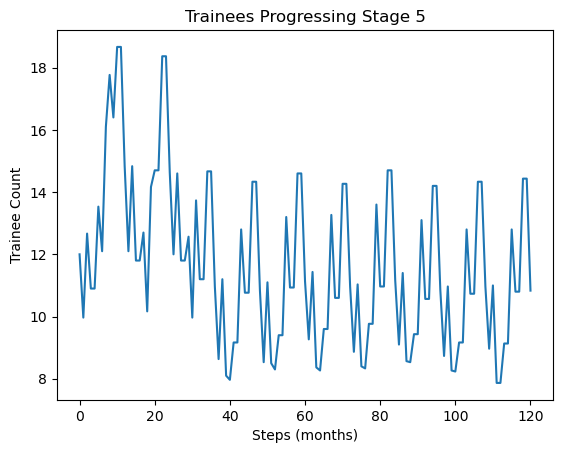

In [40]:
ax = n_df.progressing.stage5.plot(title='Trainees Progressing Stage 5')
ax.set_ylabel("Trainee Count")
ax.set_xlabel("Steps (months)")

Text(0.5, 0, 'Steps (months)')

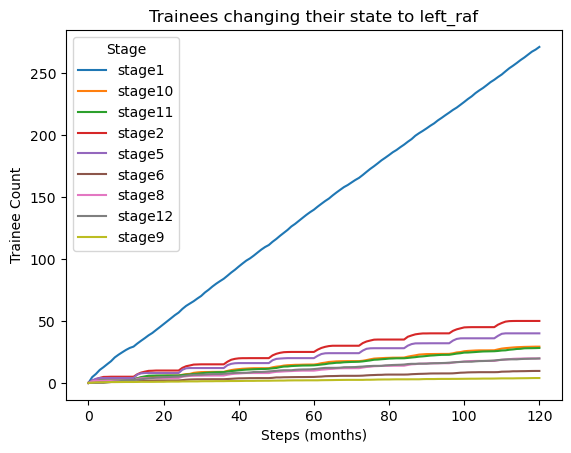

In [41]:
ax = n_df.left_raf.plot(title='Trainees changing their state to left_raf')
ax.set_ylabel("Trainee Count")
ax.set_xlabel("Steps (months)")

Text(0.5, 24.0, 'Steps (months)')

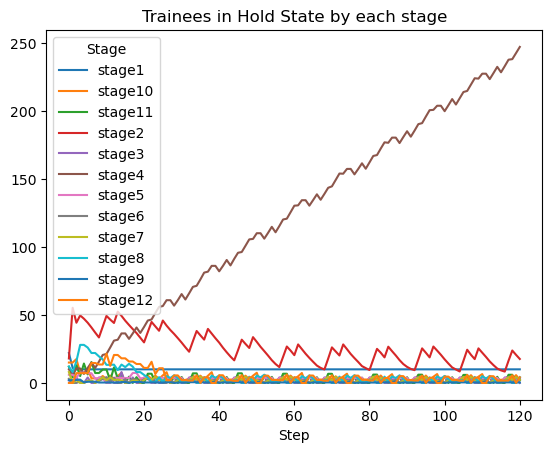

In [42]:
n_df.hold.plot(title='Trainees in Hold State by each stage')
ax.set_ylabel("Trainee Count")
ax.set_xlabel("Steps (months)")

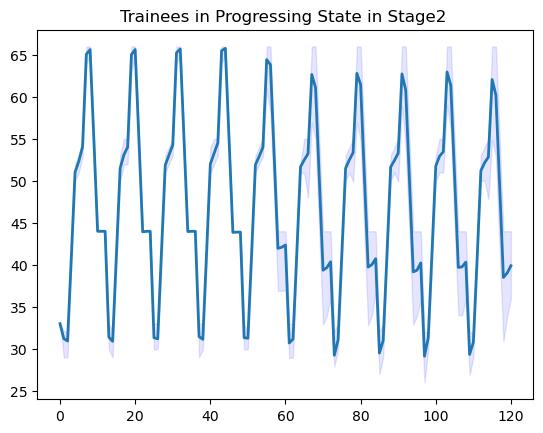

In [43]:
# Select stage
state = "progressing"
stage = "stage2"


# Compute curves of interest:
mean_path = make_average_path(simulation_data)[state][stage]
under_line_quantile = make_quantile_path(simulation_data, 0.1)[state][stage]
over_line_quantile = make_quantile_path(simulation_data, 0.9)[state][stage]

# Plotting:
plt.plot(mean_path, linewidth=2)  # mean curve.
plt.title('Trainees in Progressing State in Stage2 ')
plt.fill_between(
    mean_path.index, under_line_quantile, over_line_quantile, color="b", alpha=0.1
)